#### Third party libraries

In [1]:
## Numerical Computation library
import numpy as np
import pandas as pd

## Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Parallization
from joblib import Parallel
from joblib import delayed


In [2]:
def load_data(filepath):
    data = pd.read_csv(filepath,header=None)
    X = data.to_numpy()
    return X

### Dataset filepaths

In [3]:
first_dataset = './clustering_datasets/first_clustering_dataset.csv'
second_dataset = './clustering_datasets/second_clustering_dataset.csv'
third_dataset = './clustering_datasets/third_clustering_dataset.csv'

#### I wrote codes in HW7 package

In [4]:
from HW7 import KMeans
from HW7 import LLoydAlgorithm
from HW7 import StandardScaler

# HW6: Clustering I (K-means from scrach) [20pts]



You must implement wanted algorithms from scratch and without using the prepared libraries.

In K-means clustering, we are given points x
$x_1, ..., x_n ∈ R^d$
 and an integer $K > 1$, and our goal is to
minimize the within-cluster sum of squares (also known as the k-means objective)

$J(C, L)=\sum_{i=1}^n ||x_i - C_{l_i}||^2$

where $C = (C_1, ..., C_K)$ are the cluster centers $(Cj ∈ R^d)$, and $L = (l_1, ..., l_n)$ are the cluster assignments ($l_i ∈ \{1, ..., K\}$).

Finding the exact minimum of this function is computationally difficult. The most common algorithm for finding an approximate solution is Lloyd’s algorithm, which takes as input the set of points and some initial cluster centers C, and proceeds as follows:

1. Keeping C fixed, find cluster assignments L to minimize J(C, L). This step only involves finding nearest neighbors. Ties can be broken using arbitrary (but consistent) rules.
1. Keeping L fixed, find C to minimize J(C, L). This is a simple step that only involves averaging points within a cluster.
1. If any of the values in L changed from the previous iteration (or if this was the first iteration), repeat from step i.
1. Return C and L.

The initial cluster centers C given as input to the algorithm are often picked randomly from $x_1, ..., x_n$. In practice, we often repeat multiple runs of Lloyd’s algorithm with different initializations, and pick the best resulting clustering in terms of the k-means objective. You’re about to see why.

### a) [5 points]
Implement Lloyd’s algorithm. Run it until convergence 200 times, each time initializing using K cluster centers picked at random from the set ${x_1, ..., x_n}$, with $K = 5$ clusters,
on the 500 two dimensional data points in *hw6_first_clustering_dataset.csv*. Plot in a single figure the original data, and all $200 × 5$ cluster centers given by each run of Lloyd’s algorithm. You can play around with the plotting options such as point sizes so that the cluster centers are clearly visible. Also compute the minimum, mean, and standard deviation of the within-cluster sums of squares for the clusterings given by each of the 200 runs.

If you get an empty cluster, it has no center of mass. In this case, initialize the empty cluster center again (not all centers).

### Answer:
LLoyed Algorithm is implemented in "HW5.kmeans.LLoydAlgorithm",
And Kmeans based on lloyd algorithm implemented in "HW5.kmeans.KMeans"

#### First I load dataset

(-0.16051798191475736, 0.3905865317857603, -3.59913728324009, 3.28070911973957)

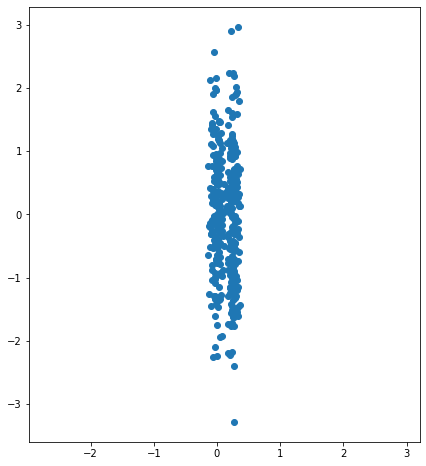

In [5]:
X = load_data(first_dataset)
plt.figure(figsize=(7,8))
plt.scatter(X[:,0],X[:,1])
plt.axis('equal')
#plt.savefig('Data1.png')

I use LLoydAlgorithm code that i wrote in HW5 as base code, and add necessary functionality for thid exercise to it.

In [6]:
class ExcerciseA(KMeans):
    def fit(self,X,y=None):  
        tasks = [
            LLoydAlgorithm(
                n_clusters=self.n_clusters,
                init=self.init,
                tol=self.tol,
                n_iter=self.n_iter,
            )
            for _ in range(self.n_init)
        ]
        tasks = np.array(Parallel(n_jobs=self.n_jobs)(delayed(task.fit)(X) for task in tasks))
        inertias = np.array([task.inertia_ for task in tasks])
        epochs = np.array([task.epochs_ for task in tasks])
        self.model_ = tasks[np.argmin(inertias)]
        self.assignments_ = self.model_.assignments_
        self.centroids_ = self.model_.centroids_
        self.inertia_ = self.model_.inertia_
        self.epochs_ = self.model_.epochs_
        
        mins = np.empty((self.n_init,),dtype='float32')
        means = np.empty((self.n_init,),dtype='float32')
        stds = np.empty((self.n_init,),dtype='float32')
        
        datas = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self.compute_info)(X,task) for task in tasks))
            
        return tasks,datas[:,0],datas[:,1],datas[:,2],epochs
    
    def compute_info(self, X,model):
        distances = np.linalg.norm(X - model.centroids_[model.assignments_], axis=1)
        mean = np.mean(distances)
        std = np.std(distances)
        min_ = np.min(distances)
        return min_,mean,std

#### Now we train our model

In [7]:
model = ExcerciseA(n_clusters=5,init='random',n_init=200)
tasks,mins,means,stds,epochs = model.fit(X)

#### Check number of iteration for Convergence

In [8]:
print(f'Mean num iteration for convergence: {np.mean(epochs)}')
print(f'std num iteration for convergence: {np.std(epochs)}')
print(f'Max num iteration for convergence: {np.max(epochs)}')
print(f'Min num iteration for convergence: {np.min(epochs)}')

Mean num iteration for convergence: 10.655
std num iteration for convergence: 4.407490782747027
Max num iteration for convergence: 23
Min num iteration for convergence: 3


#### Plot $\mu,\sigma,min$ of distances

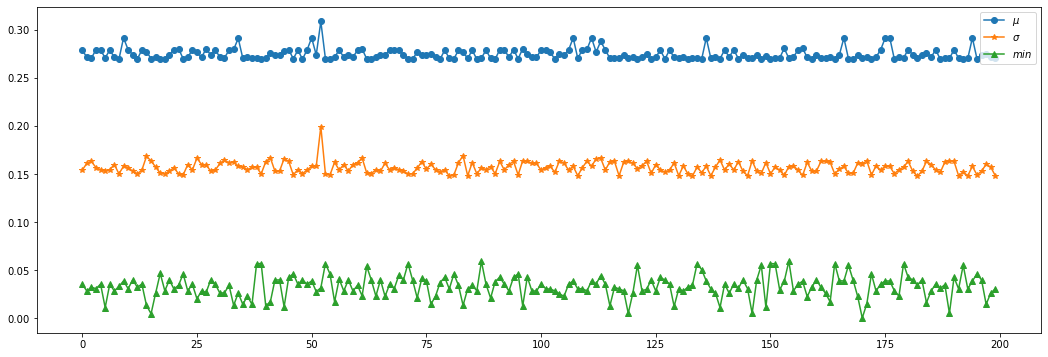

In [9]:
plt.figure(figsize=(18,6))
plt.plot(means,marker='o',label='$\\mu$')
plt.plot(stds,marker='*',label='$\\sigma$')
plt.plot(mins,marker='^',label='$min$')
plt.legend()
#plt.savefig('random_init_error.png')

#### Centroids

(-0.16051798191475736, 0.3905865317857603, -3.59913728324009, 3.28070911973957)

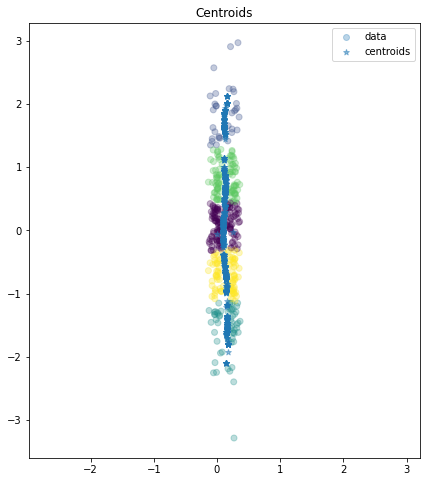

In [10]:
centroids = np.array([task.centroids_ for task in tasks])
xs = np.empty((len(centroids),5),dtype='int32')

xs = xs.flatten()
plt.figure(figsize=(7,8))

plt.title('Centroids')
plt.scatter(X[:,0],X[:,1],c= model.assignments_,alpha=0.3,label='data')
plt.scatter(centroids[:,:,0],centroids[:,:,1],marker='*',label='centroids',alpha=0.5)
plt.legend()
plt.axis('equal')
#plt.savefig('centroids_random_model.png')

#### Our best model:

In [11]:
print(f'Best model inertia: {model.inertia_}')
print(f'Best model epochs: {model.epochs_}')

Best model inertia: 0.2693334887267782
Best model epochs: 8


(-0.16051798191475736, 0.3905865317857603, -3.59913728324009, 3.28070911973957)

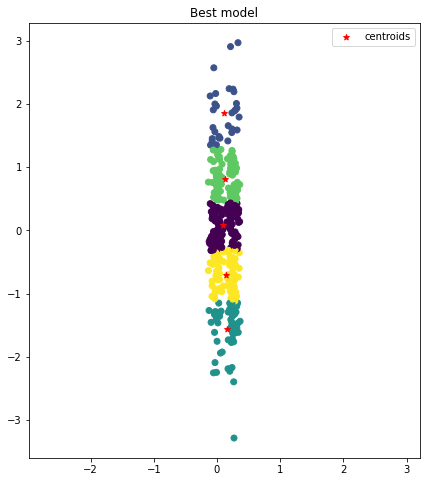

In [12]:
plt.figure(figsize=(7,8))

plt.title('Best model')
plt.scatter(X[:,0],X[:,1],c= model.assignments_)
plt.scatter(model.centroids_[:,0],model.centroids_[:,1],marker='*',label='centroids',c='r')
plt.legend()
plt.axis('equal')
#plt.savefig('random_best_model.png')

### b) [5 points]

Kmeans++ is an initialization algorithm for K-means proposed by David Arthur
and Sergei Vassilvitskii in 2007:

1. Pick the first cluster center $C_1$ uniformly at random from the data $x_1, ..., x_n$. In other words, we first pick an index i uniformly at random from $\{1, ..., n\}$, then set $C_1 = x_i$.

2. For $j = 2, ..., K$:
  * For each data point, compute its distance $D_i$ to the nearest cluster center picked in a previous iteration:
  $D_i = \min_{j'=1,...,j-1}||x_i-C_{j'}||$
  * Pick the cluster center $C_j$ at random from $x_1, ..., x_n$ with probabilities proportional to $D^2_1,..., D^2_n$. Precisely, we pick an index $i$ at random from $\{1, ..., n\}$ with probabilities
equal to $\frac{D^2_1}{\sum_{i'=1}^n{D^2_{i'}}}, ...., \frac{D^2_n}{\sum_{i'=1}^n{D^2_{i'}}}$ , and set $C_j = x_i$.
3. Return C as the initial cluster  ssignments for Lloyd’s algorithm.


Replicate the figure and calculations in part (b) using Kmeans++ as the initialization algorithm, instead of picking C uniformly at random.

### Answer
KMeans++ initializer is implemented in "HW5.initializer.kmeanplus_initilizer"

#### Now we train our model

In [13]:
model = ExcerciseA(n_clusters=5,init='k-means++',n_init=200)
tasks,mins,means,stds,epochs = model.fit(X)

#### Check number of iteration for Convergence

In [14]:
print(f'Mean num iteration for convergence: {np.mean(epochs)}')
print(f'std num iteration for convergence: {np.std(epochs)}')
print(f'Max num iteration for convergence: {np.max(epochs)}')
print(f'Min num iteration for convergence: {np.min(epochs)}')

Mean num iteration for convergence: 9.645
std num iteration for convergence: 4.429331213625822
Max num iteration for convergence: 24
Min num iteration for convergence: 2


#### Plot $\mu,\sigma,min$ of distances

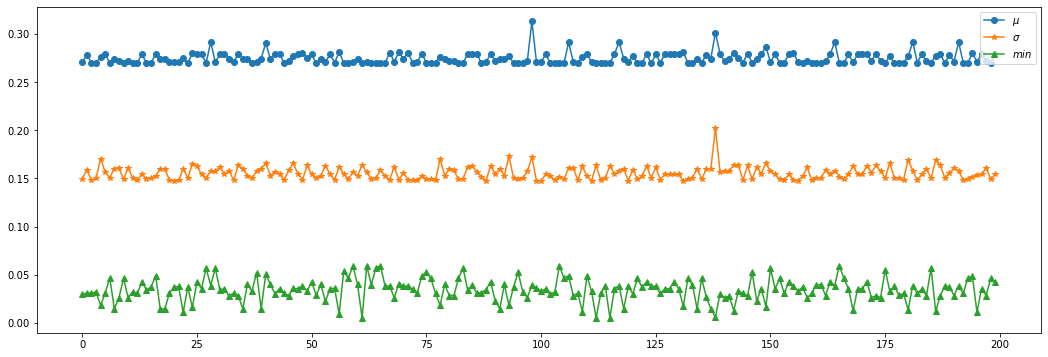

In [15]:
plt.figure(figsize=(18,6))
plt.plot(means,marker='o',label='$\\mu$')
plt.plot(stds,marker='*',label='$\\sigma$')
plt.plot(mins,marker='^',label='$min$')
plt.legend()
#plt.savefig('plus_init_error.png')

#### Centroids

(-0.16051798191475736, 0.3905865317857603, -3.59913728324009, 3.28070911973957)

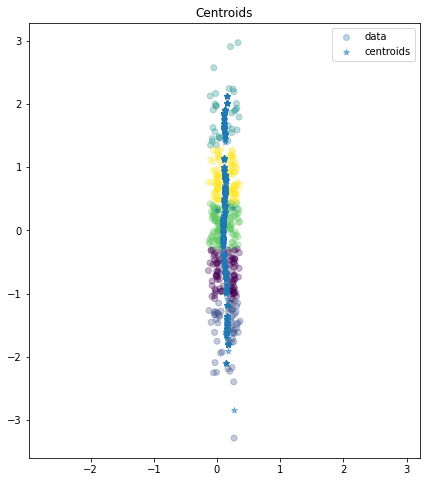

In [16]:
centroids = np.array([task.centroids_ for task in tasks])
xs = np.empty((len(centroids),5),dtype='int32')

xs = xs.flatten()
plt.figure(figsize=(7,8))

plt.title('Centroids')
plt.scatter(X[:,0],X[:,1],c= model.assignments_,alpha=0.3,label='data')
plt.scatter(centroids[:,:,0],centroids[:,:,1],marker='*',label='centroids',alpha=0.5)
plt.legend()
plt.axis('equal')
#plt.savefig('centroids_plus_model.png')

#### Our best model

In [17]:
print(f'Best model inertia: {model.inertia_}')
print(f'Best model epochs: {model.epochs_}')

Best model inertia: 0.2692713567386712
Best model epochs: 6


(-0.16051798191475736, 0.3905865317857603, -3.59913728324009, 3.28070911973957)

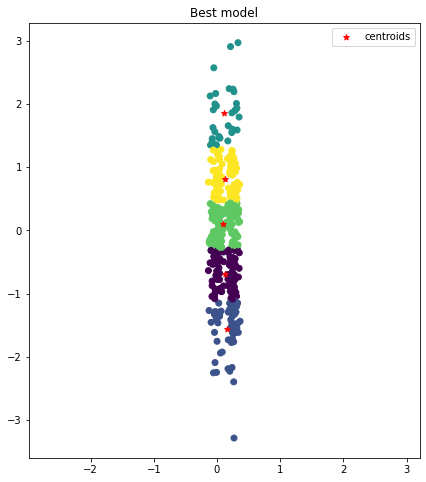

In [18]:
plt.figure(figsize=(7,8))

plt.title('Best model')
plt.scatter(X[:,0],X[:,1],c= model.assignments_)
plt.scatter(model.centroids_[:,0],model.centroids_[:,1],marker='*',label='centroids',c='r')
plt.legend()
plt.axis('equal')
#plt.savefig('plus_best_model.png')

Hopefully your results make it clear how sensitive Lloyd’s algorithm is to initializations, even in
such a simple, two dimensional data set!

### c) [2 points]

A common way to pick K is as follows. For each value of K in some range (e.g. $K = 1, ..., n$, or some subset), we find an approximate minimum of the k-means objective using our favorite algorithm
(e.g. multiple runs of randomly initialized Lloyd’s algorithm). Then we plot the resulting values of the k-means objective against the values of K. Often, if our data set is such that there exists a natural value for K, we see a “knee” in this plot, i.e. a value for K where the rate at which the within-cluster sum of squares is decreasing sharply reduces. This suggests we should use the value for K where this knee occurs. In the toy example in below Figure, this value would be K = 6.

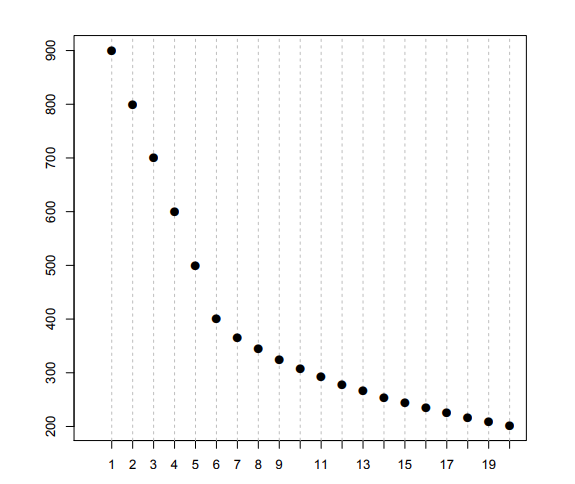

 Produce a plot similar to the one in Figure 1 for $K = 1, ..., 15$ using the data set in (b), and show where the “knee” is. For each value of K, run k-means with at least 200 initializations and pick the best resulting clustering (in terms of the objective) to ensure you get close to the global minimum.

**** your answer****

I just run it with 10 initilization because it's enough.

In [19]:
models = Parallel(n_jobs=-1)(delayed(KMeans(n_clusters=k,n_init=10,).fit)(X) for k in range(1,16))

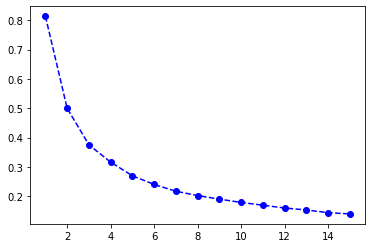

In [20]:
inertias = [model.inertia_ for model in models]

plt.plot(range(1,16),inertias,'b--',marker='o')
#plt.savefig('c.png')

### d) [3 points]

 Repeat part (e) with the data set in *HW6_second_clustering_dataset.csv*. Find 2 knees in the resulting plot (you may need to plot the square root of the within-cluster sum of squares instead, in order to make the second knee
obvious). Explain why we get 2 knees for this data set (consider plotting the data to see what’s going on).

**** your answer****

(-4.230199779237212, 30.422901667448762, -3.5393935397997893, 24.9797260573618)

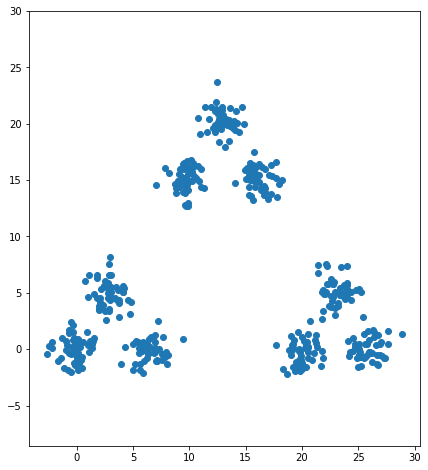

In [21]:
X = load_data(second_dataset)
plt.figure(figsize=(7,8))
plt.scatter(X[:,0],X[:,1])
plt.axis('equal')
#plt.savefig('Data2.png')

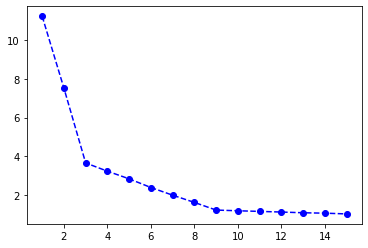

In [22]:
models = Parallel(n_jobs=-1)(delayed(KMeans(n_clusters=k,n_init=10,).fit)(X) for k in range(1,16))

inertias = [model.inertia_ for model in models]
plt.plot(range(1,16),inertias,'b--',marker='o')
#plt.savefig('d.png')

In [23]:
model3 = models[2]
model9 = models[8]

(-4.230199779237212, 30.422901667448762, -3.5393935397997893, 24.9797260573618)

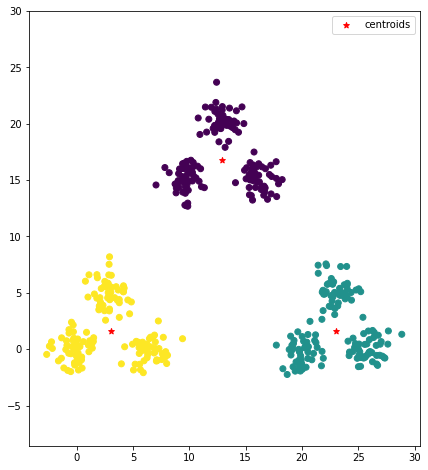

In [24]:
plt.figure(figsize=(7,8))

plt.scatter(X[:,0],X[:,1],c= model3.assignments_)
plt.scatter(model3.centroids_[:,0],model3.centroids_[:,1],marker='*',label='centroids',c='r')
plt.legend()
plt.axis('equal')
#plt.savefig('model3.png')

(-4.230199779237212, 30.422901667448762, -3.5393935397997893, 24.9797260573618)

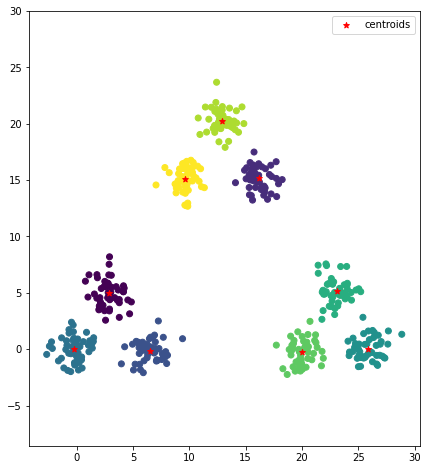

In [25]:
plt.figure(figsize=(7,8))

plt.scatter(X[:,0],X[:,1],c= model9.assignments_)
plt.scatter(model9.centroids_[:,0],model9.centroids_[:,1],marker='*',label='centroids',c='r')
plt.legend()
plt.axis('equal')
#plt.savefig('model9.png')

There are 2 knees. One in 3 and one in 9.

We conclude our exploration of k-means clustering with the critical importance of properly scaling the dimensions of your data.

### e) [2 points]

 Load the data in *HW6_third_clustering_dataset.csv*.
csv. Perform k-means clustering on this data with K = 2 with 500 initializations. Plot the original data, and overplot the 2 cluster centers.

**** your answer****

(-1.6106904296803102, 5.313531531390169, -1.737091880453342, 3.231393793536562)

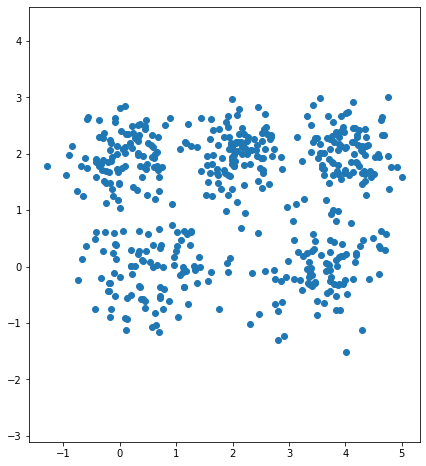

In [26]:
X = load_data(third_dataset)
plt.figure(figsize=(7,8))
plt.scatter(X[:,0],X[:,1])
plt.axis('equal')
#plt.savefig('Data3.png')

model.inertia_= 1.2748400475123502


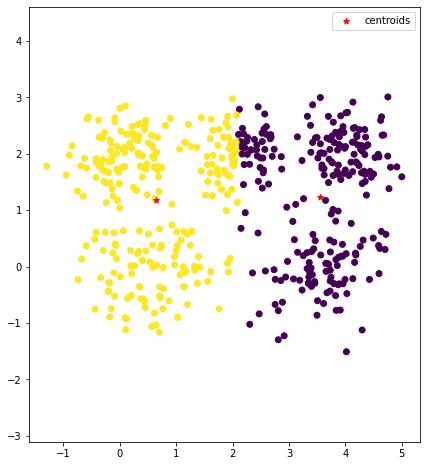

In [27]:
plt.figure(figsize=(7,8))

model = KMeans(n_clusters=2,n_init=500,n_jobs=-1)
model.fit(X)
plt.scatter(X[:,0],X[:,1],c= model.assignments_)
plt.scatter(model.centroids_[:,0],model.centroids_[:,1],marker='*',label='centroids',c='r')
plt.legend()
plt.axis('equal')
#plt.savefig('e.png')
print(f'model.inertia_= {model.inertia_}')

### f) [3 points]

Normalize the features in this data set, i.e. first center the data to be mean 0
in every dimension, then rescale each dimension to have unit variance. Repeat part (g) with this modified data.

**** your answer****

model.inertia_= 0.9872006340176447


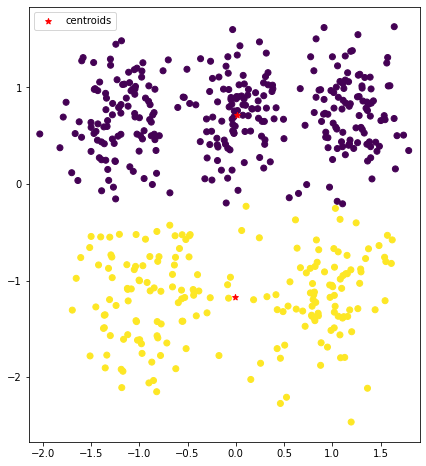

In [28]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

model = KMeans(n_clusters=2,n_init=500,n_jobs=-1)
model.fit(scaled_X)

plt.figure(figsize=(7,8))

plt.scatter(scaled_X[:,0],scaled_X[:,1],c= model.assignments_)
plt.scatter(model.centroids_[:,0],model.centroids_[:,1],marker='*',label='centroids',c='r')
plt.legend()
plt.axis('equal')
#plt.savefig('f.png')
print(f'model.inertia_= {model.inertia_}')

As you can see, the results are radically different. You should not take this to mean that data should always be normalized. In some problems, the relative values of the dimensions are meaningful and should be preserved (e.g. the coordinates of earthquake epicenters in a region). But in others, the dimensions are on entirely different scales (e.g. age in years v.s. income in thousands of dollars).
Proper pre-processing of data for clustering is often part of the art of machine learning.